# Simulating the Physics of a Curveball
Arwen Sadler and Leila Merzenich

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question

For this project, we made a simulation modeling the behavior of a curveball in order to determine what the ideal angle to throw the ball would be so that it hits the strike zone.

## Method

According to [the MLB website](https://www.mlb.com/news/statcast-spin-rate-compared-to-velocity/c-160896926), the average speed of a curveball in the 2015 season was 78.2 mph, or about 34.96 m/s, and that the average rpm was 2,308.

We estimated the height at which the ball leaves the pitcher's hand by watching slow-motion videos of curveball pitches and using the pitcher's height as a reference.

We found the angle of throw by sweeping angles between 0 and 5 degrees through a function that returned the final height of the ball when it reaches home plate, knowing that we wanted the height to be in the center of the strike zone (about 0.93 m).

In [2]:
params = Params(x = 0, 
                y = 1.7,
                z = 0, # A line connecting the mound to home plate
                g = 9.8, #gravity
                mass = 145e-3,
                diameter = 73e-3,
                rho = 1.2,
                C_d = 0.33,
                angle_xy = 10, #angle of throw b/w x and y axes--2.17 w/ no rotation
                angle_yz = 35, #angle of rotation b/w y and z axes
                angle_xz = 12, #angle from the x axis to the z axis (0 is along the x axis)
                velocity = 34.96,
                rps = 2308 / 60
                )

,values
x,0.000000
y,1.700000
z,0.000000
g,9.800000
mass,0.145000
diameter,0.073000
rho,1.200000
C_d,0.330000
angle_xy,10.000000
angle_yz,35.000000


In [3]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    t_end = 10
    
    # convert x-y angle to radians
    theta_xy = np.deg2rad(angle_xy)
    
    # compute total x & z magnitude and y components of velocity
    vxz_mag, vy = pol2cart(theta_xy, velocity)
    
    # convert x-z angle to radians
    theta_xz = np.deg2rad(angle_xz)
    
    # compute x and z components of velocity
    vx, vz = pol2cart(theta_xz, vxz_mag) 
    
    # make the initial state
    init = State(x=x, y=y, z=z, vx=vx, vy=vy, vz=vz)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area, t_end=t_end)

In [4]:
system = make_system(params)

,values
x,0
y,1.7
z,0
g,9.8
mass,0.145
diameter,0.073
rho,1.2
C_d,0.33
angle_xy,10
angle_yz,35


In [5]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity Vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = rho * v.mag**2 * C_d * area / 2
    direction = -v.hat()
    f_drag = direction * mag
    return f_drag

In [6]:
v_test = Vector(10, 10)
drag_force(v_test, system)

<Quantity([-0.11719681 -0.11719681], 'dimensionless')>

Magnus Force also effects the path of the ball. According to NASA, the lift on a sphere caused by Magnus Force is:

L = 16/3 (pi^2 * r^3 * s * rho * V)

Where s is the angular velocity of the ball, r is the radius of the ball, rho is the density of the air, and V is the velocity of the air in comparison to the velocity of the ball.

In [7]:
def mag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity Vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    
    # convert angle_yz to radians
    theta_yz = np.deg2rad(angle_yz)
    
    # convert angle_xz to radians
    theta_xz = np.deg2rad(angle_xz+90)
    
    # compute magnus force direction
    lzx_mag, ly = pol2cart(theta_yz, 1)
    lx, lz = pol2cart(theta_xz, lzx_mag)
    s = Vector(lx, ly, lz)
    
    mag = 16/3 * (np.pi**2 * (diameter/2)**3 * rps * rho * v.mag) #Assuming air velocity is 0
    direction = -s.hat()#the direction it's rotating, a unit vector in the system
    L = direction * mag
    
    return L

In [8]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, z, vx, vy, vz = state
    unpack(system)

    v = Vector(vx, vy, vz)    
    a_drag = drag_force(v, system) / mass
    a_grav = Vector(0, -g, 0)
    a_mag = mag_force(v, system) / mass
    
    a = a_grav + a_drag + a_mag
    
    return vx, vy, vz, a.x, a.y, a.z

In [9]:
slope_func(system.init, 0, system)

(33.67652543412124,
 6.070740291235884,
 7.15816645526986,
 <Quantity(-1.8770521832226574, 'dimensionless')>,
 <Quantity(-27.352414168499262, 'dimensionless')>,
 <Quantity(-24.25546248579969, 'dimensionless')>)

In [10]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, z, vx, vy, vz = state
    return x - 18.44

In [11]:
event_func(system.init, 0, system)

-18.44

In [12]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step=0.1)
details

,values
sol,None
t_events,[[0.5555880475250194]]
nfev,56
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [13]:
#How long the ball flew for
flight_time = get_last_label(results)

0.5555880475250194

In [14]:
#How far the ball flew
x_dist = get_last_value(results.x)

18.44

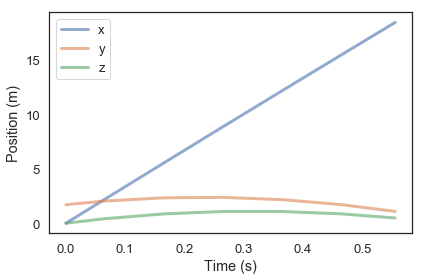

In [15]:
plot(results.x, label='x')
plot(results.y, label='y')
plot(results.z, label='z')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

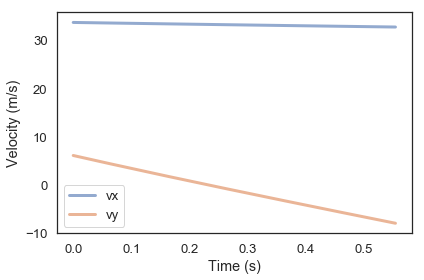

In [16]:
plot(results.vx, label='vx')
plot(results.vy, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

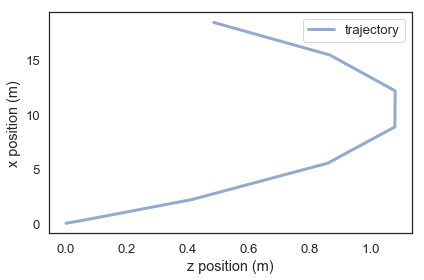

In [17]:
def plot_trajectory(results):
    plot(results.z, results.x, label='trajectory')

    decorate(xlabel='z position (m)',
             ylabel='x position (m)')
    
plot_trajectory(results)

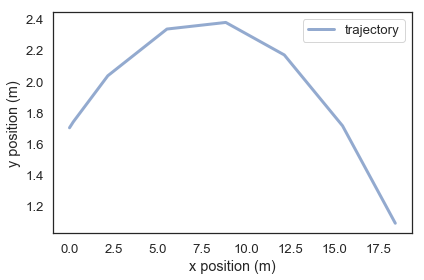

In [18]:
def plot_trajectory2(results):
    plot(results.x, results.y, label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')
    
plot_trajectory2(results)

In [19]:
def error_func_fsolve(xz_guess, params):
    
    print(xz_guess)
    system = make_system(Params(params, angle_xz = xz_guess))
    
    results, details = run_ode_solver(system, slope_func, events = event_func)
    
    end = get_last_value(results.z)
    
    return end

In [20]:
solution = fsolve(error_func_fsolve, 10.5, params)

10.5
[10.5]
[10.5]
[10.5]
[10.50000016]
[10.49175679]
[10.49175689]


array([10.49175689])

In [21]:
def error_func_fsolve_xy(xy_guess, params):
    
    print(xy_guess)
    system = make_system(Params(params, angle_xy = xy_guess))
    
    results, details = run_ode_solver(system, slope_func, events = event_func)
    
    end = get_last_value(results.y)
    
    return end - 1

In [22]:
solutionxy = fsolve(error_func_fsolve_xy, 10, params)

10
[10]
[10.]
[10.]
[10.00000015]
[9.72462627]
[9.72468867]
[9.72468865]


array([9.72468865])

In [27]:
def run_optimal_simulation(params, solution, solutionxy):
    system = make_system(Params(params, angle_xy = solutionxy, angle_xz = solution))
    
    results, details = run_ode_solver(system, slope_func, events = event_func, max_step = 0.05)
    
    return results

In [28]:
results = run_optimal_simulation(params, solution, solutionxy)

,x,y,z,vx,vy,vz
0.000000,0.000000,1.700000,0.000000,33.881558,5.905237,6.274534
0.000058,0.001966,1.700343,0.000364,33.881412,5.903652,6.273130
0.000638,0.021627,1.703764,0.004000,33.879950,5.887801,6.259090
0.006441,0.218185,1.737470,0.039914,33.865351,5.729499,6.118928
0.056441,1.908338,1.990108,0.315966,33.741309,4.380337,4.928019
0.106441,3.592363,2.175912,0.533171,33.620110,3.055630,3.764407
0.156441,5.270390,2.296031,0.692799,33.501363,1.752524,2.624339
0.206441,6.942534,2.351480,0.795938,33.384703,0.468375,1.504300
0.256441,8.608889,2.343144,0.843507,33.269785,-0.799264,0.400990
0.306441,10.269536,2.271791,0.836264,33.156287,-2.052658,-0.688684


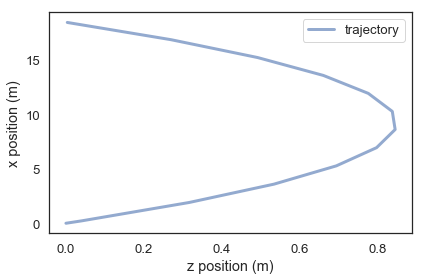

In [29]:
plot_trajectory(results)

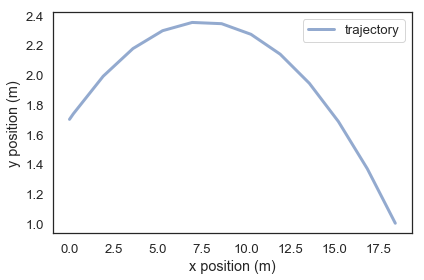

In [30]:
plot_trajectory2(results)